In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import random
import seaborn as sns

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [3]:
results_file_t = "/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/pbmc3k_tall.h5ad" 
results_file = "/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/pbmc3k_all.h5ad" 

In [4]:
adata_t = sc.read_10x_mtx(
    '/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/filtered_gene_bc_matrices/hg19/', 
    var_names = 'gene_symbols',                
    cache = True)    
adata = sc.read_10x_mtx(
    '/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/filtered_gene_bc_matrices/hg19/', 
    var_names = 'gene_symbols',                
    cache = True)

... reading from cache file cache/Users-claudiavicentecomorera-Desktop-TFG-Data-PBMC-filtered_gene_bc_matrices-hg19-matrix.h5ad
... reading from cache file cache/Users-claudiavicentecomorera-Desktop-TFG-Data-PBMC-filtered_gene_bc_matrices-hg19-matrix.h5ad


/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
adata_t.var_names_make_unique()

In [6]:
adata_t

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# PREPROCESSING

normalizing counts per cell
    finished (0:00:00)


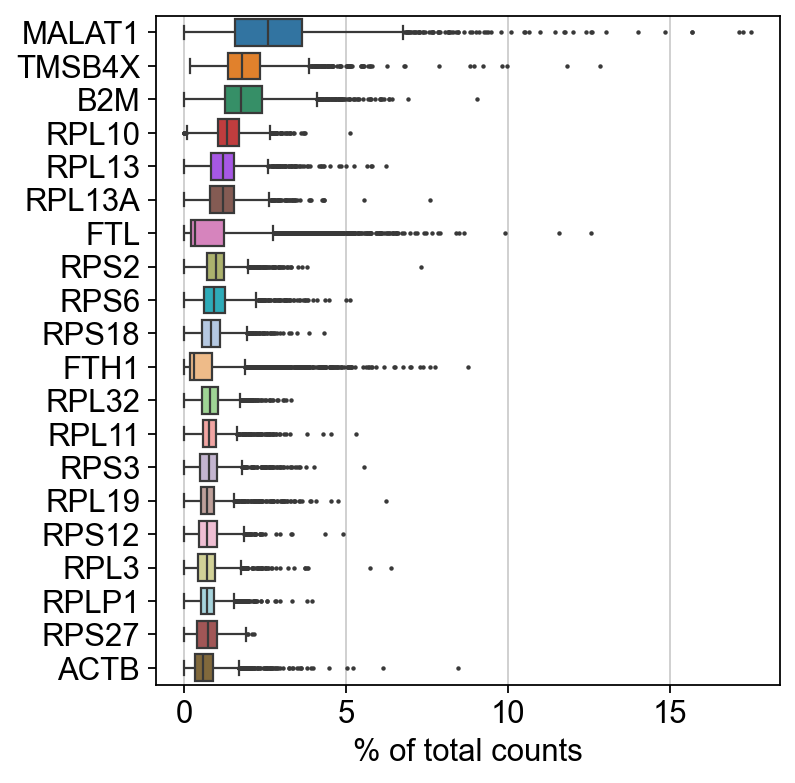

In [7]:
sc.pl.highest_expr_genes(adata_t, n_top=20, )

In [8]:
sc.pp.filter_cells(adata_t, min_genes=200)
sc.pp.filter_genes(adata_t, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
adata_t.var['mt'] = adata_t.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_t, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

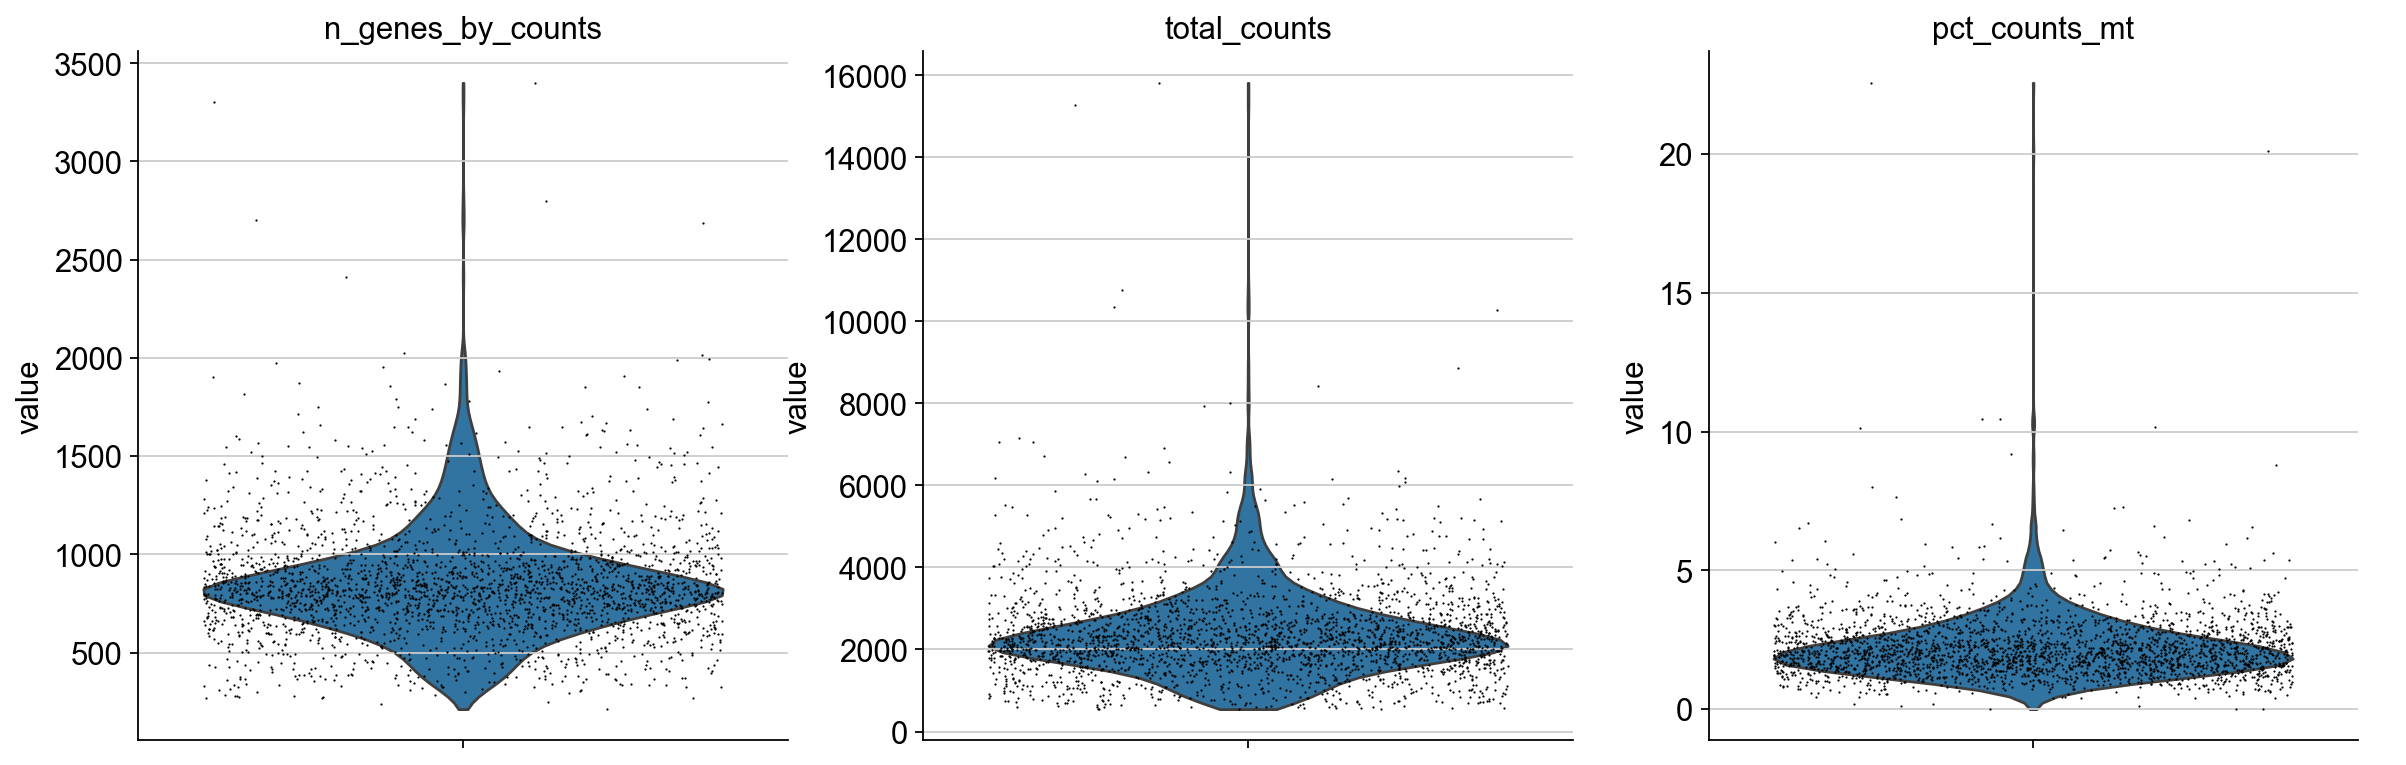

In [10]:
sc.pl.violin(adata_t, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

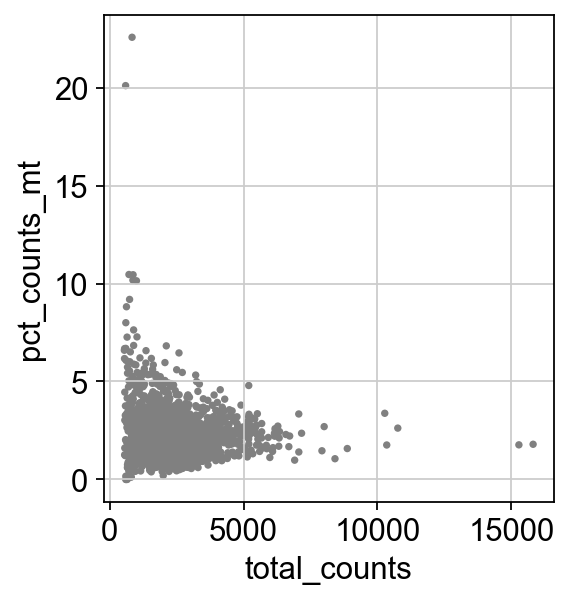

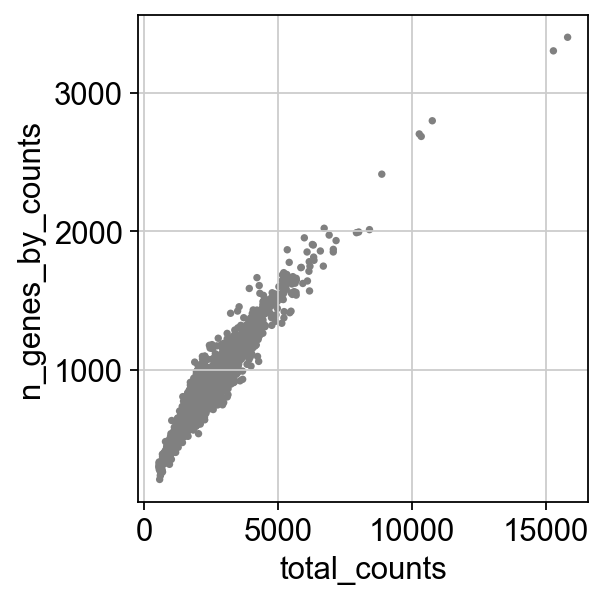

In [11]:
sc.pl.scatter(adata_t, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_t, x='total_counts', y='n_genes_by_counts')

In [12]:
adata_t = adata_t[adata_t.obs.n_genes_by_counts < 2500, :]
adata_t = adata_t[adata_t.obs.pct_counts_mt < 5, :]

In [13]:
sc.pp.normalize_total(adata_t, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.log1p(adata_t)

In [15]:
sc.pp.highly_variable_genes(adata_t, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


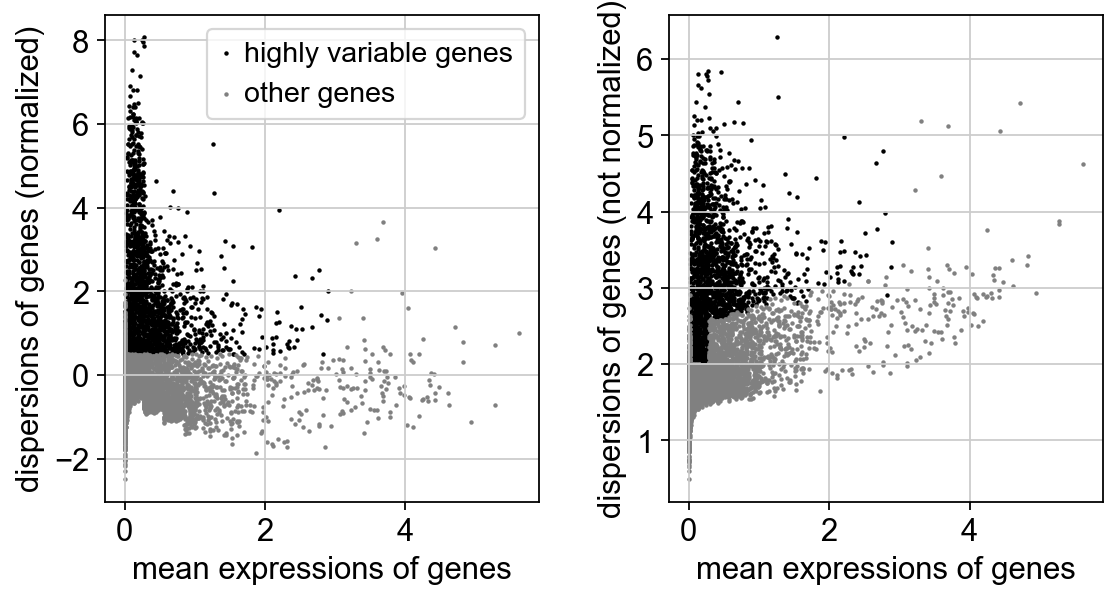

In [16]:
sc.pl.highly_variable_genes(adata_t)

In [17]:
adata_t.raw = adata_t

In [18]:
adata_t = adata_t[:, adata_t.var.highly_variable]

In [19]:
sc.pp.regress_out(adata_t, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:01)


In [20]:
sc.pp.scale(adata_t, max_value=10)

# PRINCIPAL COMPONENT ANALYSIS

In [21]:
sc.tl.pca(adata_t, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


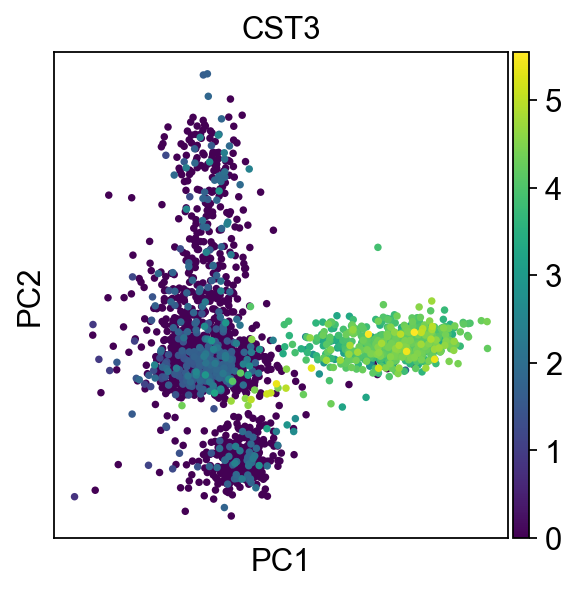

In [22]:
sc.pl.pca(adata_t, color='CST3')

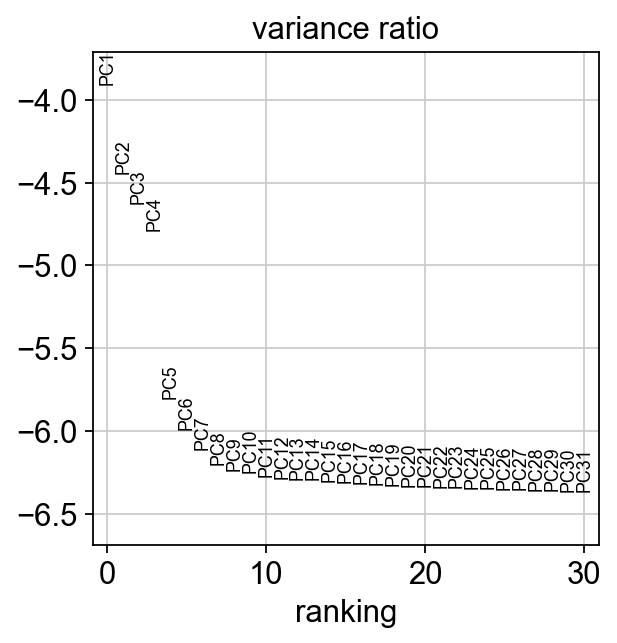

In [23]:
sc.pl.pca_variance_ratio(adata_t, log=True)

In [24]:
adata_t.write(results_file_t)

In [25]:
adata_t

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# COMPUTING THE NEIGHBORHOOD GRAPH

In [26]:
sc.pp.neighbors(adata_t, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# EMBEDDING THE NEIGHBORHOOD GRAPH

In [27]:
sc.tl.umap(adata_t)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


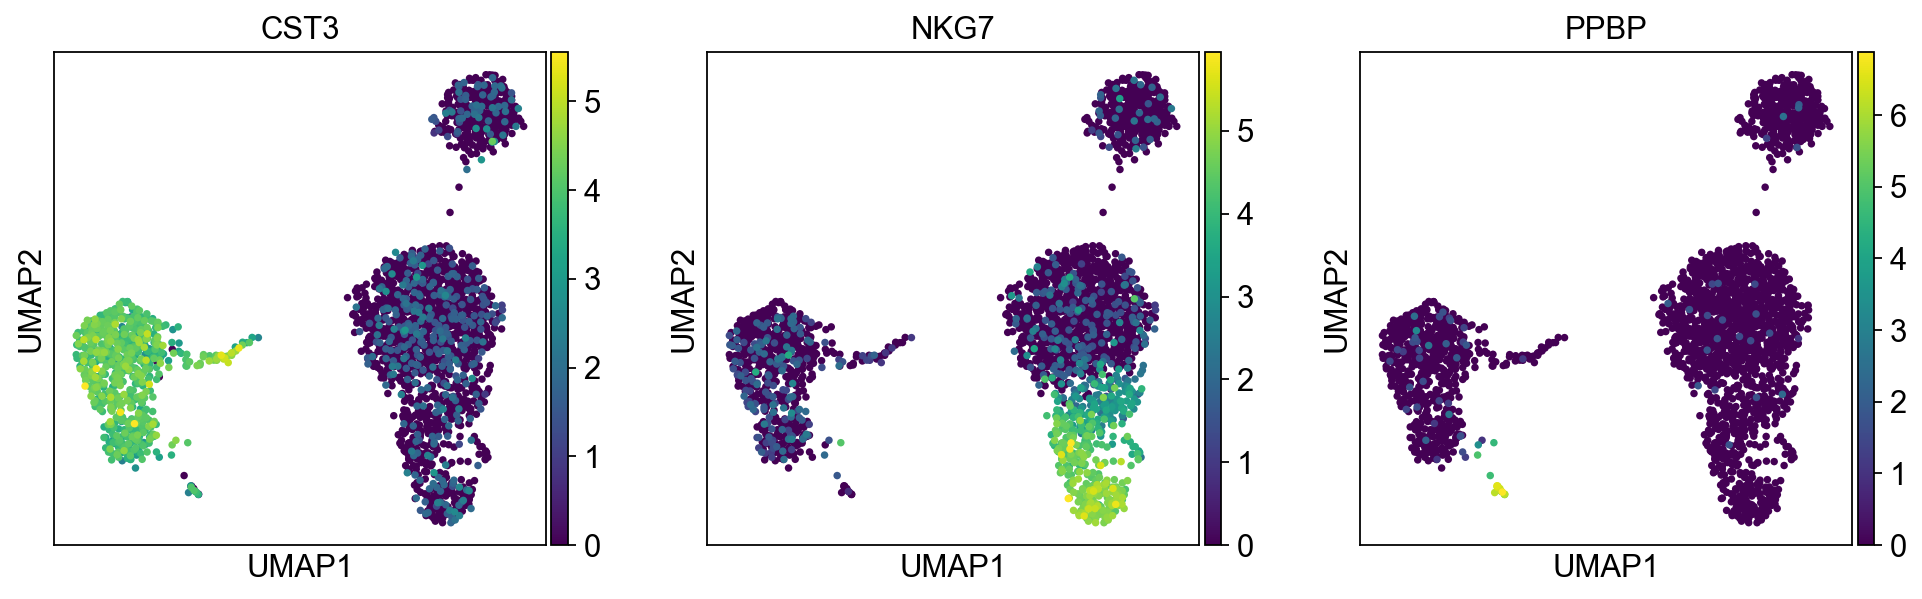

In [28]:
sc.pl.umap(adata_t, color=['CST3', 'NKG7', 'PPBP'])

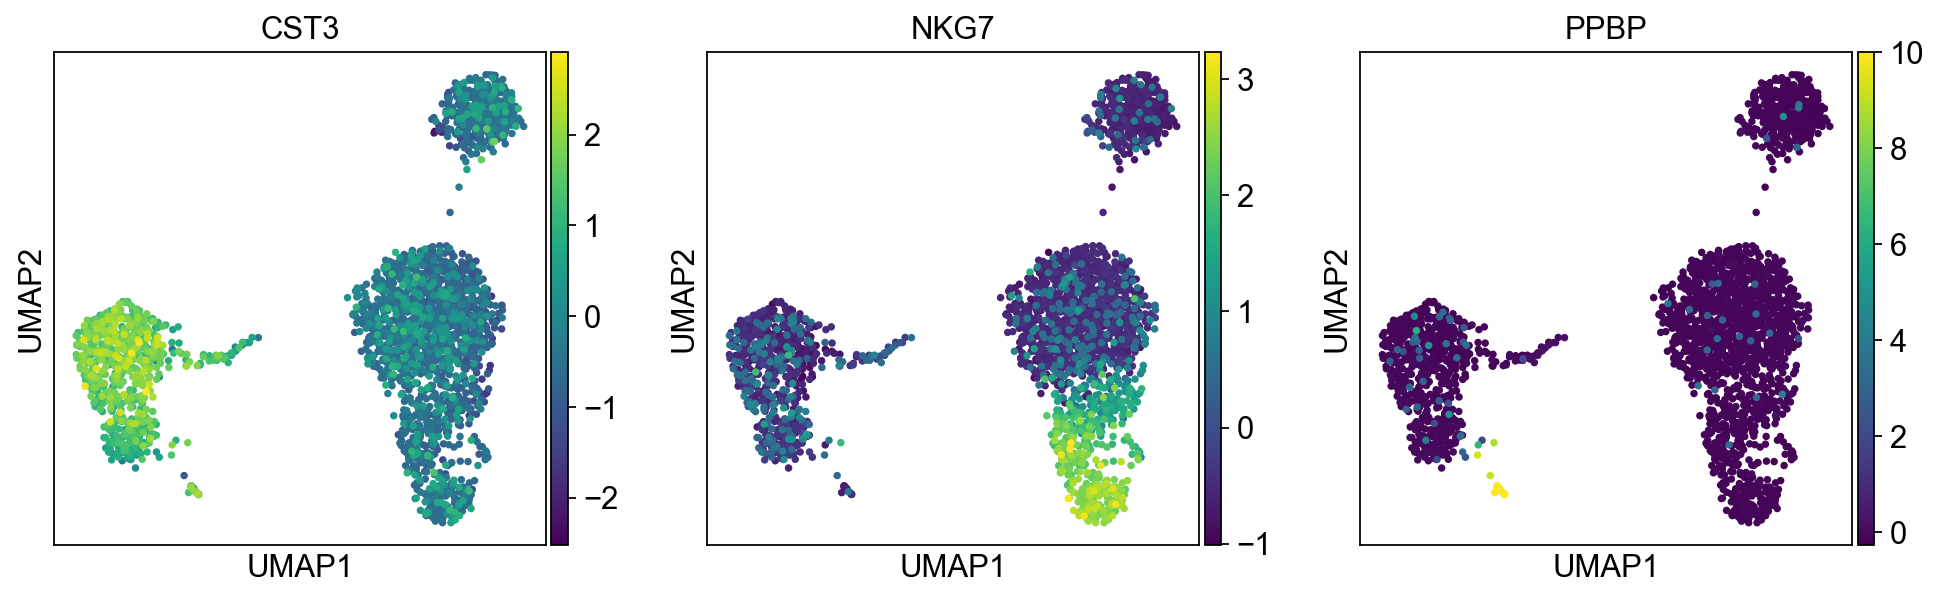

In [29]:
sc.pl.umap(adata_t, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [30]:
sc.tl.leiden(adata_t)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


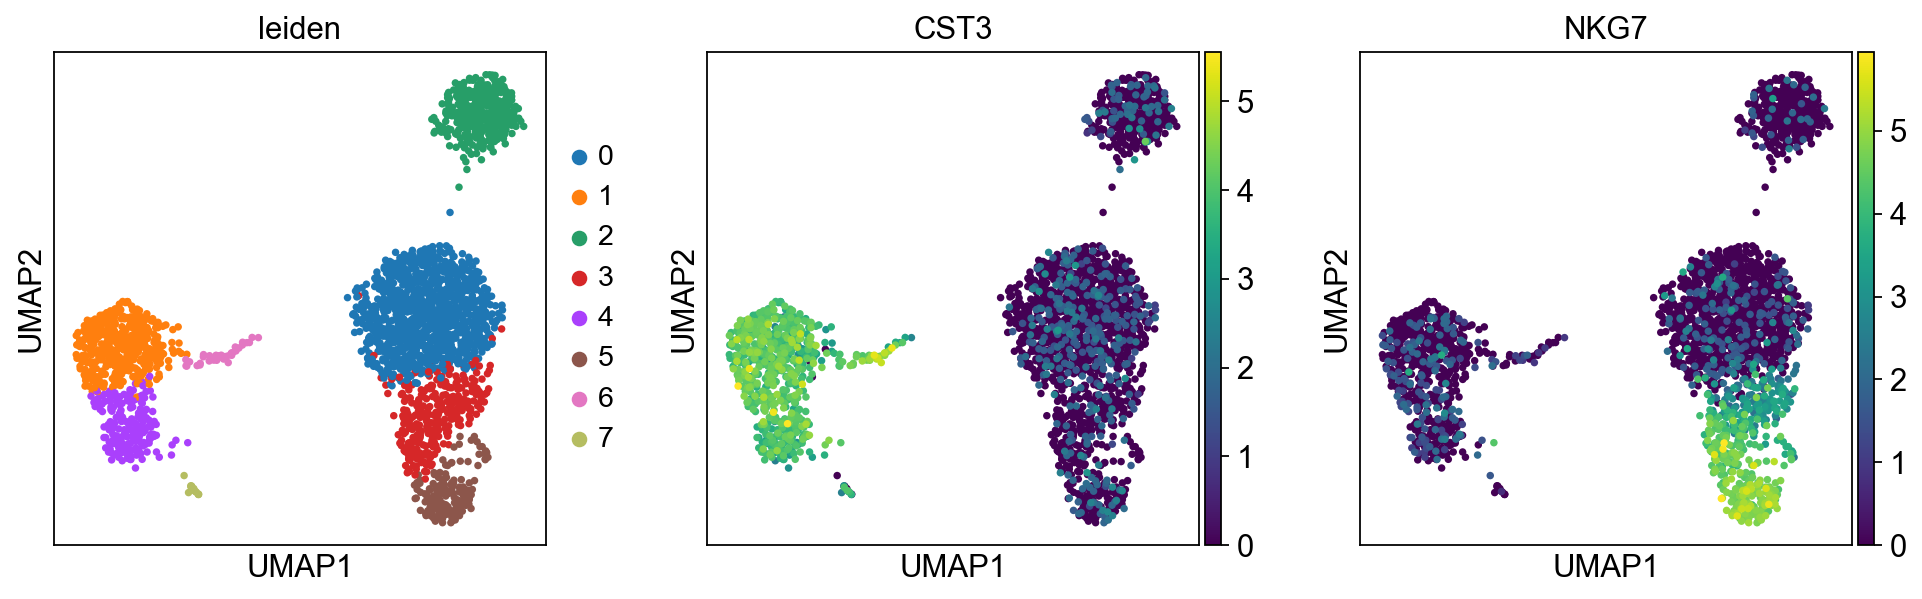

In [31]:
sc.pl.umap(adata_t, color=['leiden', 'CST3', 'NKG7'])

In [32]:
adata_t.write(results_file_t)

# FINDING MARKER GENES

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


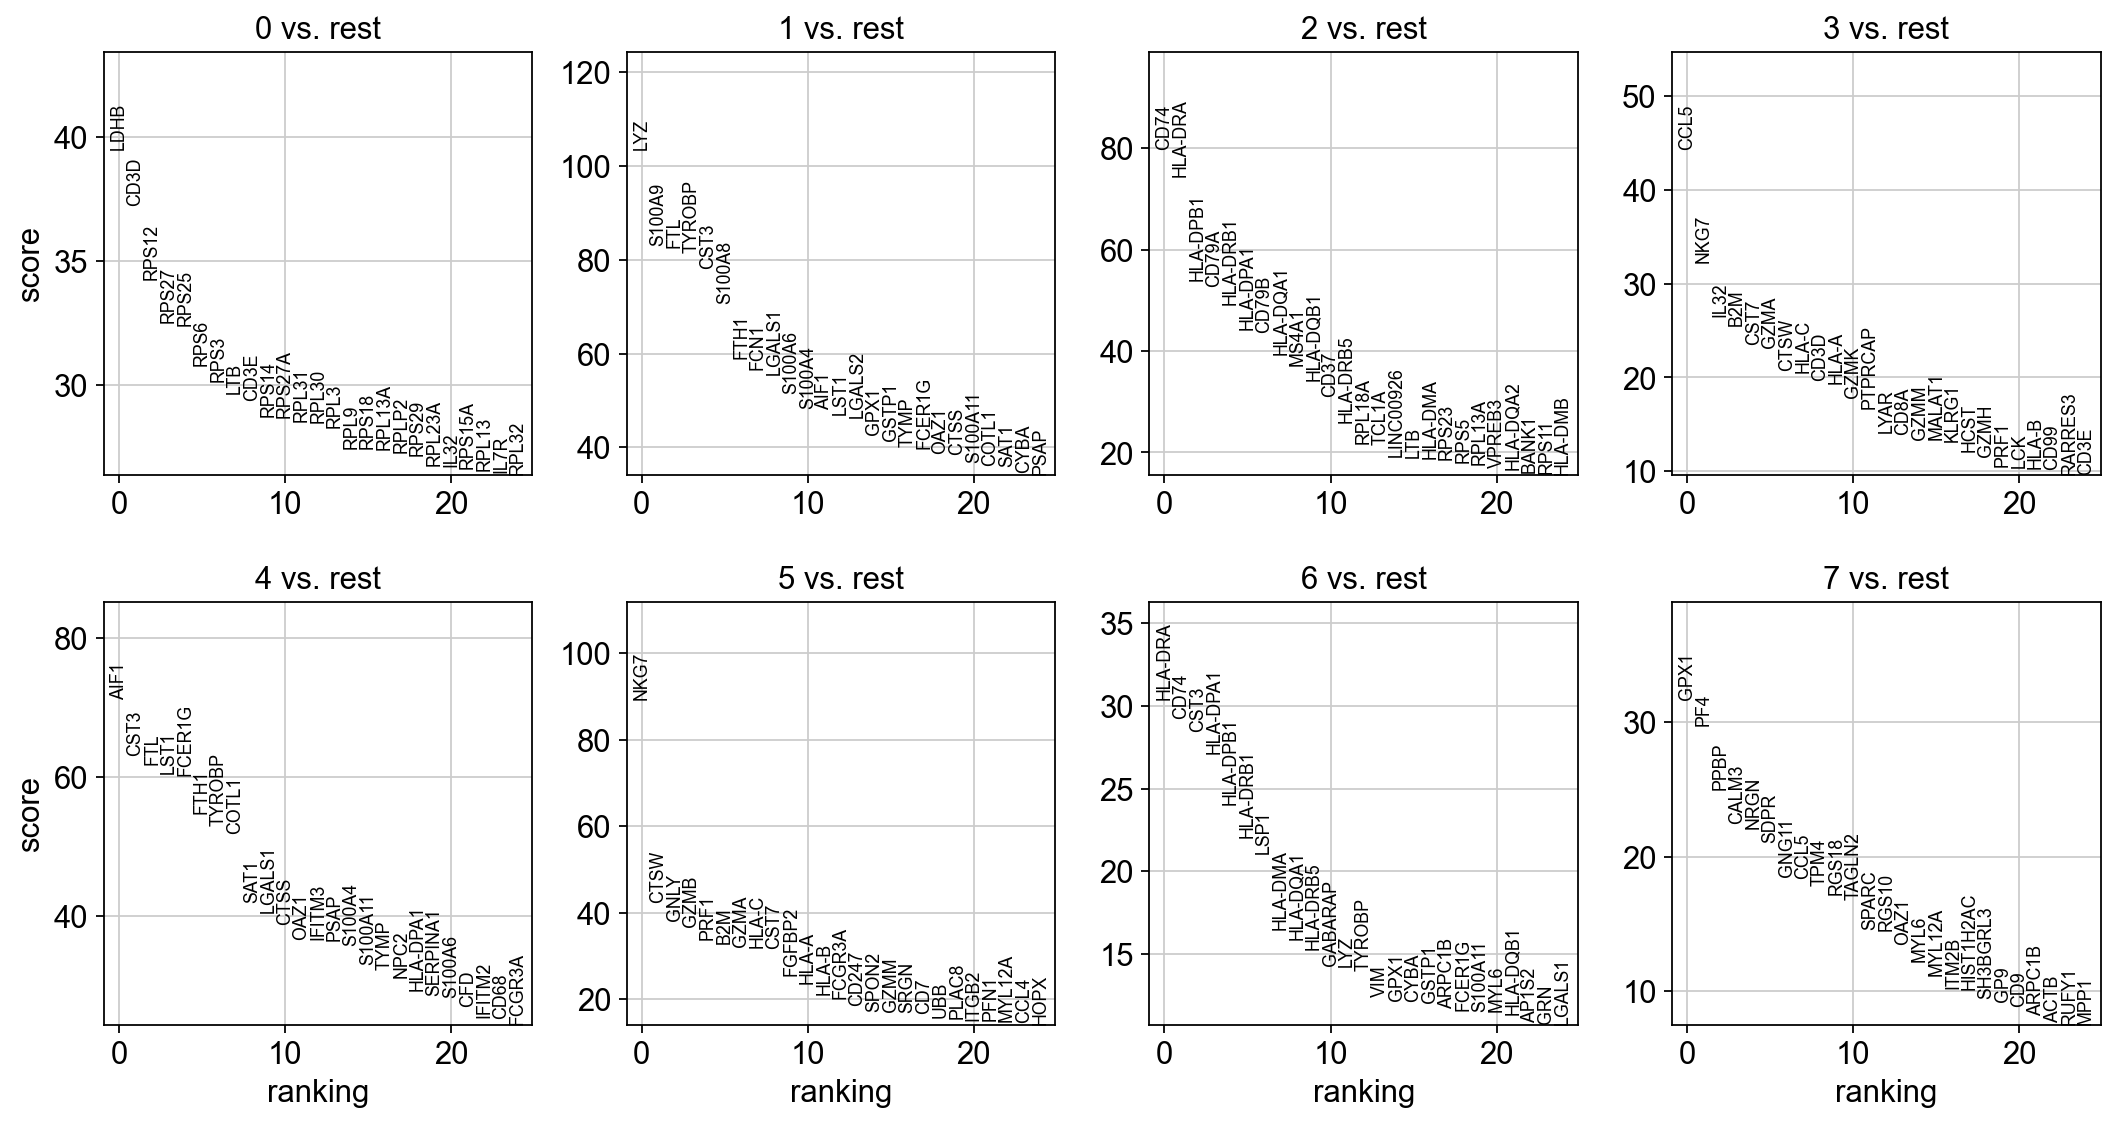

In [33]:
sc.tl.rank_genes_groups(adata_t, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_t, n_genes=25, sharey=False)

In [34]:
sc.settings.verbosity = 2

ranking genes
    finished (0:00:01)


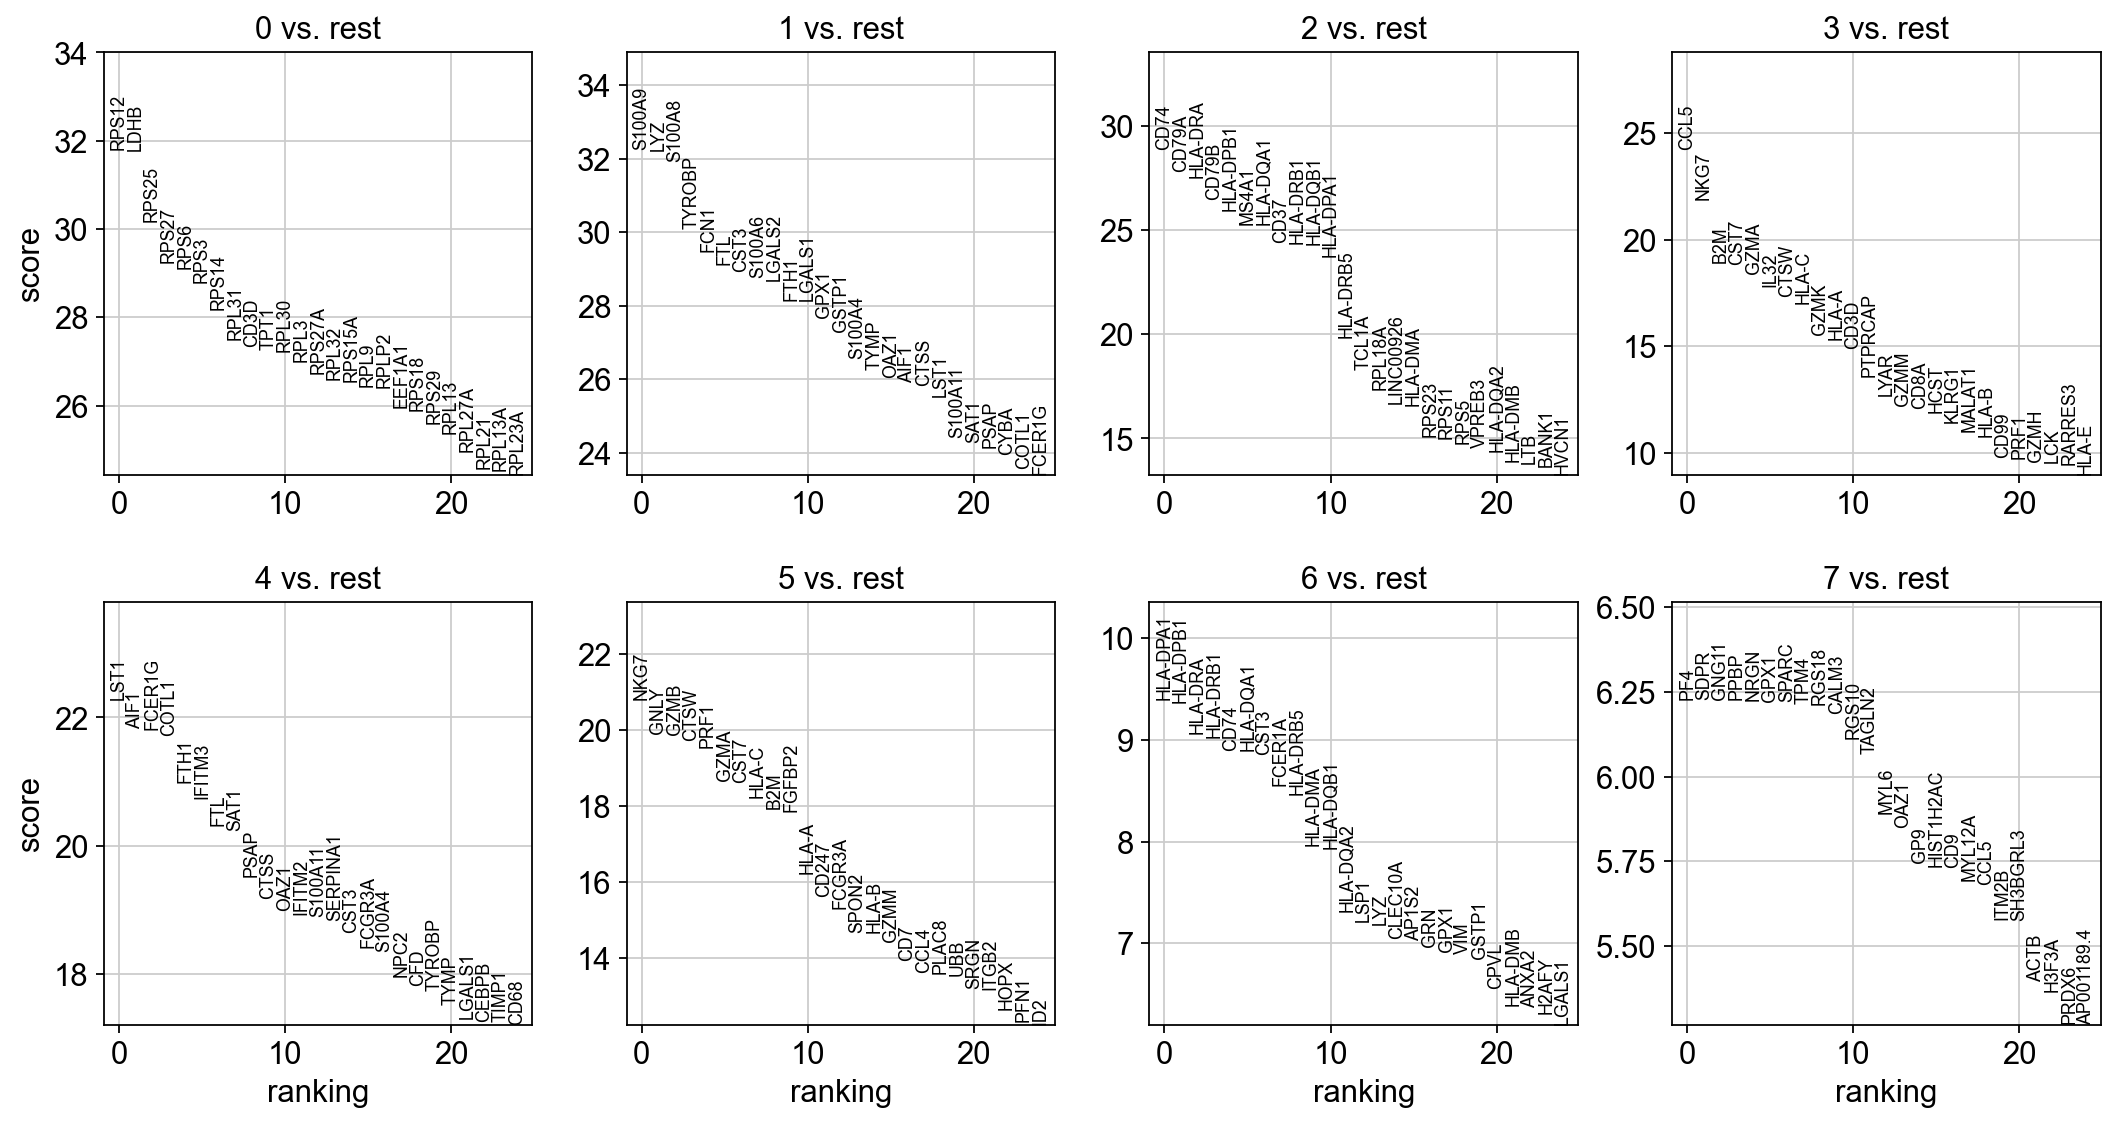

In [35]:
sc.tl.rank_genes_groups(adata_t, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_t, n_genes=25, sharey=False)

In [36]:
adata_t.write(results_file_t)

ranking genes
    finished (0:00:01)


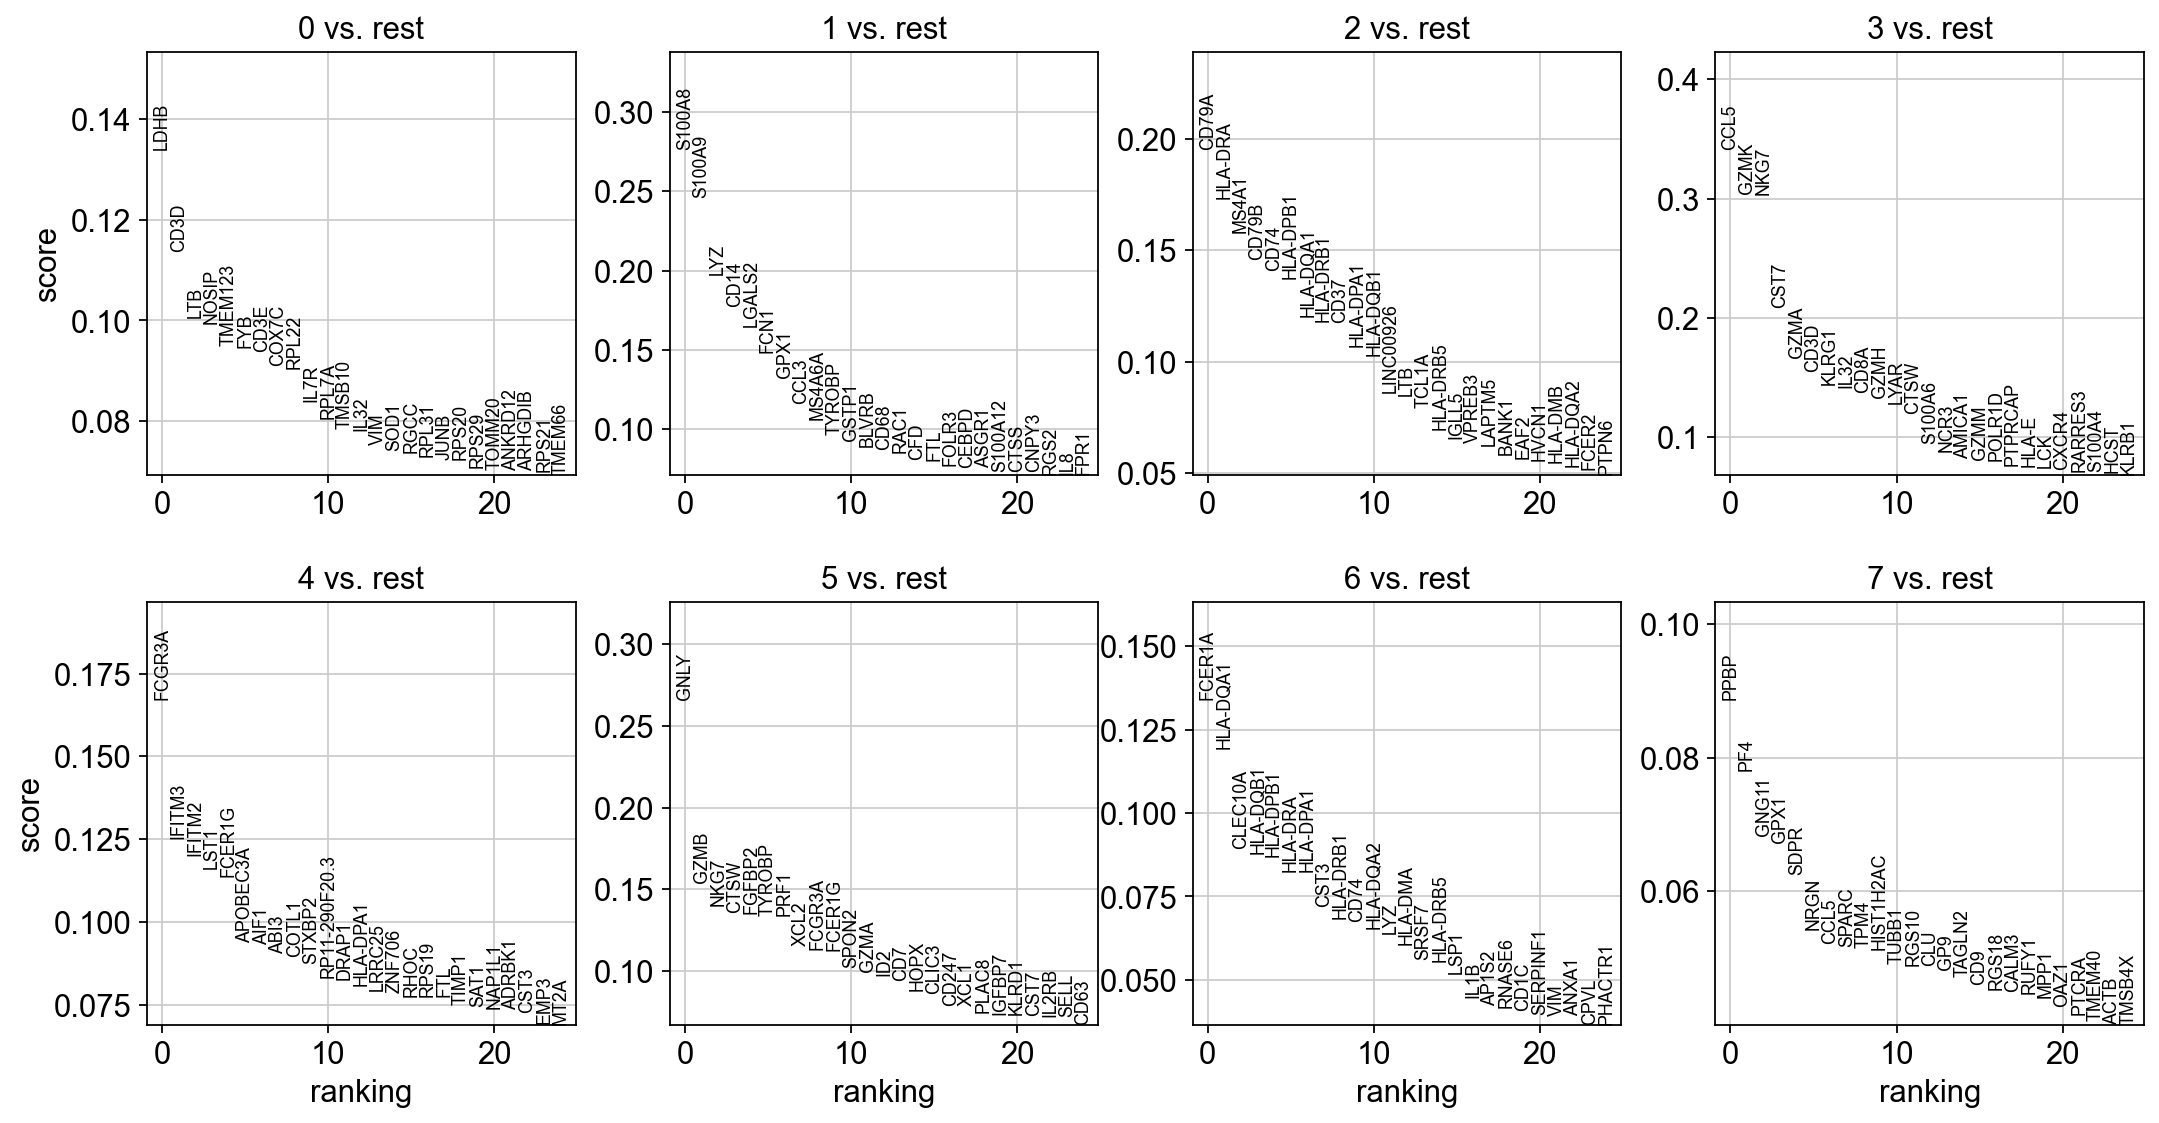

In [37]:
sc.tl.rank_genes_groups(adata_t, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata_t, n_genes=25, sharey=False)

In [38]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [39]:
adata_t = sc.read(results_file_t)

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [40]:
pd.DataFrame(adata_t.uns['rank_genes_groups']['names']).head(5)

0       1         2     3       4     5         6      7
0  RPS12  S100A9      CD74  CCL5    LST1  NKG7  HLA-DPA1    PF4
1   LDHB     LYZ     CD79A  NKG7    AIF1  GNLY  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  FCER1G  GZMB   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7   COTL1  CTSW  HLA-DRB1   PPBP
4   RPS6    FCN1  HLA-DPB1  GZMA    FTH1  PRF1      CD74   NRGN

In [41]:
result = adata_t.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  5.503264e-222  S100A9  3.165481e-228      CD74  2.487145e-183  CCL5   
1   LDHB  1.173195e-221     LYZ  1.222909e-227     CD79A  1.679730e-170  NKG7   
2  RPS25  5.404794e-200  S100A8  1.691910e-223   HLA-DRA  6.949695e-167   B2M   
3  RPS27  4.790818e-188  TYROBP  6.141017e-199     CD79B  2.569135e-154  CST7   
4   RPS6  3.706061e-186    FCN1  7.968489e-191  HLA-DPB1  3.580735e-148  GZMA   

             3_p     4_n            4_p   5_n           5_p       6_n  \
0  6.722455e-130    LST1  5.228538e-110  NKG7  4.321025e-96  HLA-DPA1   
1  2.487884e-106    AIF1  1.332400e-105  GNLY  4.640732e-88  HLA-DPB1   
2   7.459192e-80  FCER1G  1.959721e-105  GZMB  5.208282e-88   HLA-DRA   
3   3.467566e-79   COTL1  1.306716e-104  CTSW  1.202514e-86  HLA-DRB1   
4   8.067820e-76    FTH1   9.858035e-98  PRF1  5.056639e-85      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

ranking genes
    finished (0:00:00)


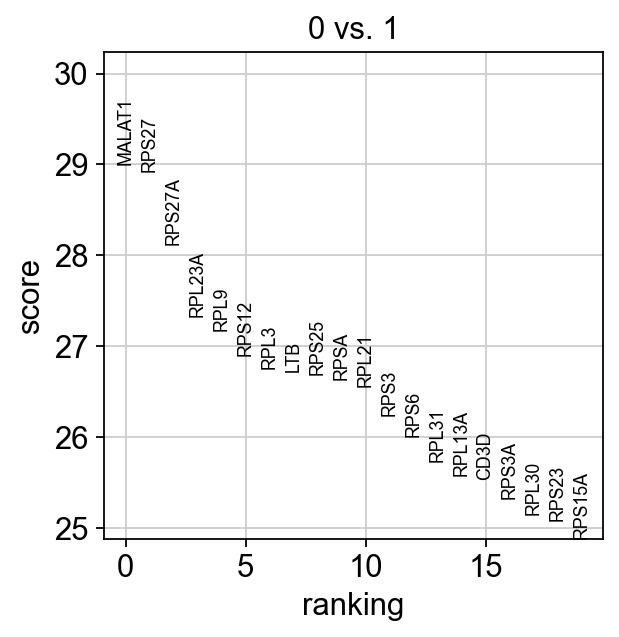

In [42]:
sc.tl.rank_genes_groups(adata_t, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata_t, groups=['0'], n_genes=20)

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


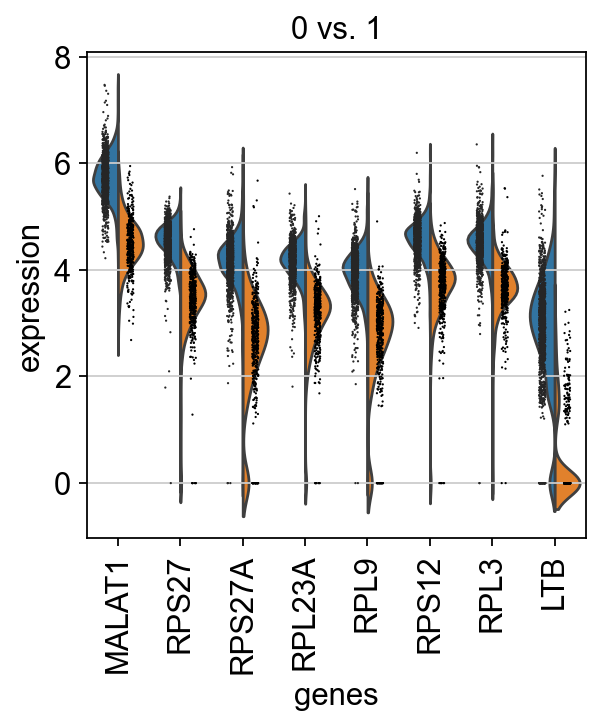

In [43]:
sc.pl.rank_genes_groups_violin(adata_t, groups='0', n_genes=8)

In [44]:
adata_t = sc.read(results_file_t)

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


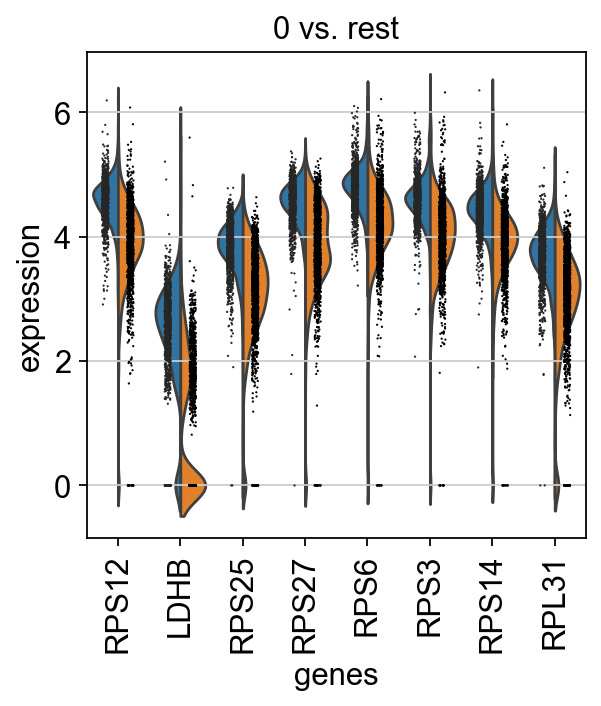

In [45]:
sc.pl.rank_genes_groups_violin(adata_t, groups='0', n_genes=8)

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The

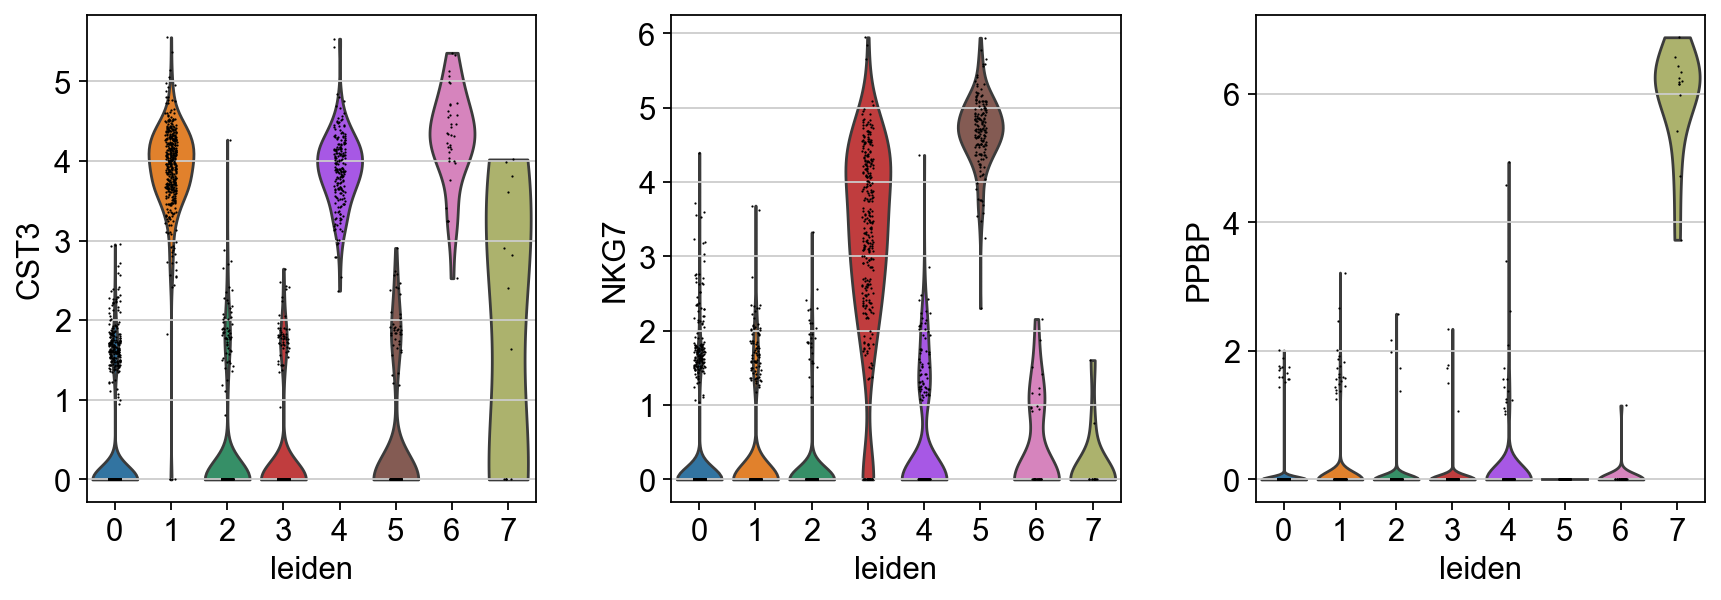

In [46]:
sc.pl.violin(adata_t, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [47]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'FCGR3A Monocytes', 'NK',
    'Dendritic', 'Megakaryocytes']
adata_t.rename_categories('leiden', new_cluster_names)

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


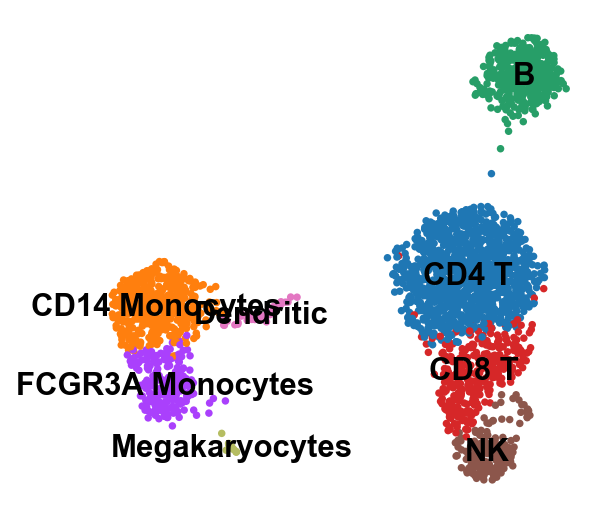

In [48]:
sc.pl.umap(adata_t, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


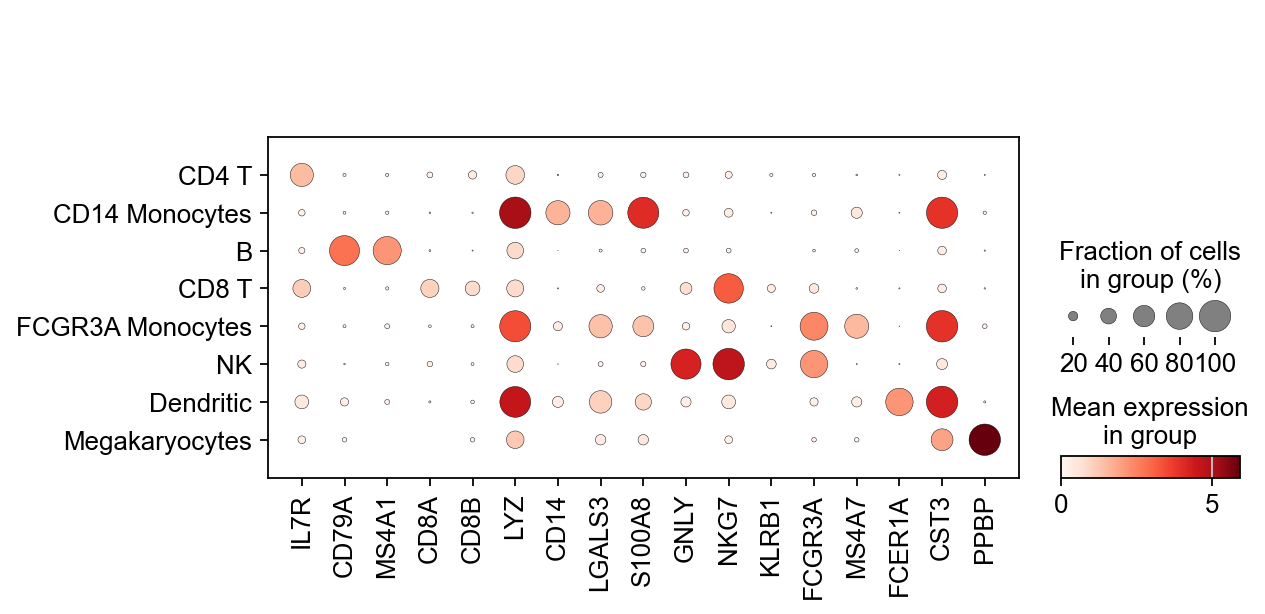

In [49]:
sc.pl.dotplot(adata_t, marker_genes, groupby='leiden');

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing 

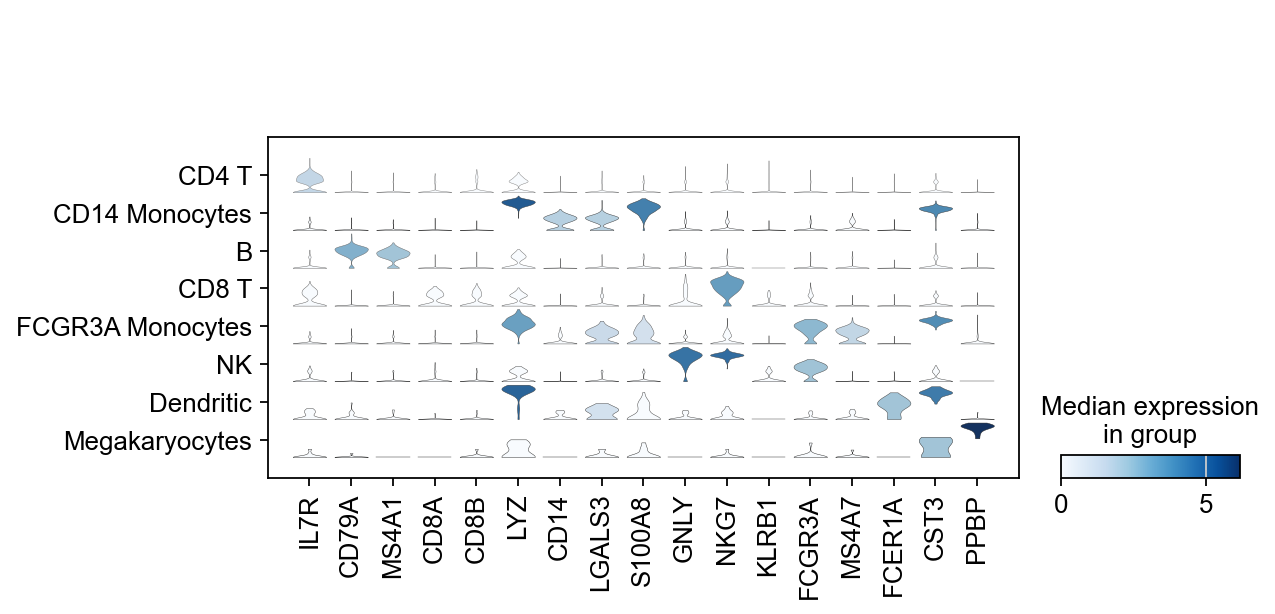

In [50]:
sc.pl.stacked_violin(adata_t, marker_genes, groupby='leiden');

In [51]:
adata_t

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [52]:
adata_t.write(results_file_t, compression='gzip')  

# PREPROCESSING FOR rFASTCORMICS

In [53]:
adata.var_names_make_unique()

In [54]:
sc.pp.filter_cells(adata, min_genes = 200)
#sc.pp.filter_genes(adata, min_cells = 3)

In [55]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

In [56]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [57]:
sc.pp.normalize_total(adata, target_sum = 1e6)  

normalizing counts per cell
    finished (0:00:00)


/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [58]:
sce.pp.magic(adata, name_list = 'all_genes')

computing MAGIC


/Users/claudiavicentecomorera/.local/lib/python3.11/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Running MAGIC with `solver='exact'` on 32738-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:00:07)


## PRINCIPAL COMPONENT ANALYSIS

In [59]:
sc.tl.pca(adata, svd_solver = 'arpack')

computing PCA
    with n_comps=50
    finished (0:00:05)


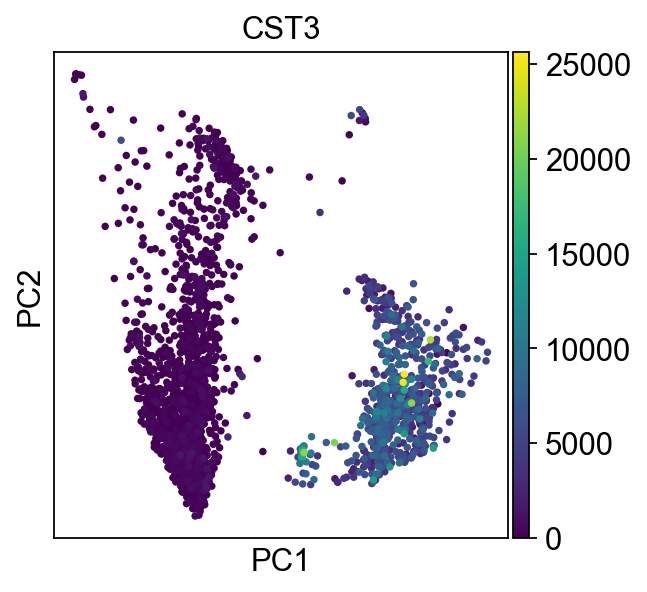

In [60]:
sc.pl.pca(adata, color = 'CST3')

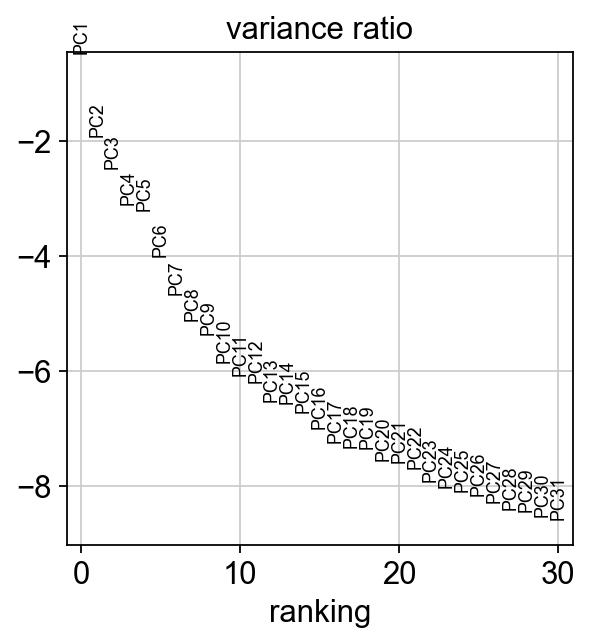

In [61]:
sc.pl.pca_variance_ratio(adata, log = True)

In [62]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## COMPUTING THE NEIGHBORHOOD GRAPH

In [63]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00)


In [64]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:02)


## CLUSTERING WITH PROCESSED DATA (adata_t) CELL-TYPES

In [66]:
adata.obs['leiden'] = adata_t.obs['leiden']

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


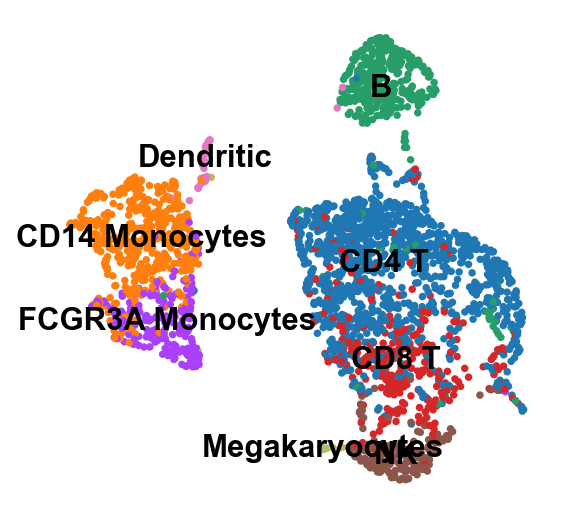

In [68]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data', title = '', frameon = False, save = '.pdf')

# DATA STORING FOR rFASTCORMICS

In [71]:
t_data = adata.to_df().transpose()
t_data.to_csv('/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/data_pbmc_ni.csv')
t_data

AAACATACAACCAC-1  AAACATTGAGCTAC-1  AAACATTGATCAGC-1  \
MIR1302-10                 0.0               0.0               0.0   
FAM138A                    0.0               0.0               0.0   
OR4F5                      0.0               0.0               0.0   
RP11-34P13.7               0.0               0.0               0.0   
RP11-34P13.8               0.0               0.0               0.0   
...                        ...               ...               ...   
AC145205.1                 0.0               0.0               0.0   
BAGE5                      0.0               0.0               0.0   
CU459201.1                 0.0               0.0               0.0   
AC002321.2                 0.0               0.0               0.0   
AC002321.1                 0.0               0.0               0.0   

              AAACCGTGCTTCCG-1  AAACCGTGTATGCG-1  AAACGCACTGGTAC-1  \
MIR1302-10                 0.0               0.0               0.0   
FAM138A                    0.0               0.0               0.0   
OR4F5                      0.0               0.0               0.0   
RP11-34P13.7               0.0               0.0               0.0   
RP11-34P13.8               0.0               0.0               0.0   
...                        ...               ...               ...   
AC145205.1                 0.0               0.0               0.0   
BAGE5                      0.0               0.0               0.0   
CU459201.1                 0.0               0.0               0.0   
AC002321.2                 0.0               0.0               0.0   
AC002321.1                 0.0               0.0               0.0   

              AAACGCTGACCAGT-1  AAACGCTGGTTCTT-1  AAACGCTGTAGCCA-1  \
MIR1302-10                 0.0               0.0               0.0   
FAM138A                    0.0               0.0               0.0   
OR4F5                      0.0               0.0               0.0   
RP11-34P13.7               0.0               0.0               0.0   
RP11-34P13.8               0.0               0.0               0.0   
...                        ...               ...               ...   
AC145205.1                 0.0               0.0               0.0   
BAGE5                      0.0               0.0               0.0   
CU459201.1                 0.0               0.0               0.0   
AC002321.2                 0.0               0.0               0.0   
AC002321.1                 0.0               0.0               0.0   

              AAACGCTGTTTCTG-1  ...  TTTCAGTGTCACGA-1  TTTCAGTGTCTATC-1  \
MIR1302-10                 0.0  ...               0.0               0.0   
FAM138A                    0.0  ...               0.0               0.0   
OR4F5                      0.0  ...               0.0               0.0   
RP11-34P13.7               0.0  ...               0.0               0.0   
RP11-34P13.8               0.0  ...               0.0               0.0   
...                        ...  ...               ...               ...   
AC145205.1                 0.0  ...               0.0               0.0   
BAGE5                      0.0  ...               0.0               0.0   
CU459201.1                 0.0  ...               0.0               0.0   
AC002321.2                 0.0  ...               0.0               0.0   
AC002321.1                 0.0  ...               0.0               0.0   

              TTTCAGTGTGCAGT-1  TTTCCAGAGGTGAG-1  TTTCGAACACCTGA-1  \
MIR1302-10                 0.0               0.0               0.0   
FAM138A                    0.0               0.0               0.0   
OR4F5                      0.0               0.0               0.0   
RP11-34P13.7               0.0               0.0               0.0   
RP11-34P13.8               0.0               0.0               0.0   
...                        ...               ...               ...   
AC145205.1                 0.0               0.0               0.0   
BAGE5                      0.0

In [70]:
df_clust = adata_t.obs['leiden'].to_frame().rename(columns={'leiden': 'Cluster_Label'}).rename_axis('Cell_Name')
df_clust.to_csv('/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/clabs_pbmc.csv')
df_clust

Cluster_Label
Cell_Name                         
AAACATACAACCAC-1             CD4 T
AAACATTGAGCTAC-1                 B
AAACATTGATCAGC-1             CD4 T
AAACCGTGCTTCCG-1  FCGR3A Monocytes
AAACCGTGTATGCG-1                NK
...                            ...
TTTCGAACTCTCAT-1    CD14 Monocytes
TTTCTACTGAGGCA-1                 B
TTTCTACTTCCTCG-1                 B
TTTGCATGAGAGGC-1                 B
TTTGCATGCCTCAC-1             CD4 T

[2638 rows x 1 columns]